In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

np.random.seed(0)

## Generate data, Estimators

In [3]:
# params
p = 200
c2 = 30
n2 = c2 * p
sigma = 10.0

# covariates
X2 = np.random.randn(n2, p)

# models
beta_t = np.random.randn(p, 1)
d = 0.13
beta_s = beta_t + d * np.random.randn(p, 1)

# labels
Y2 = X2 @ beta_t + sigma * np.random.randn(n2, 1)
hat_beta_t = np.linalg.inv(X2.T @ X2) @ X2.T @ Y2

# test data
#test_n2 = n2 * c2 * 5
#test_X2 = np.random.randn(test_n2, p)
#test_Y2 = test_X2 @ beta_t

#te_beta_t = np.linalg.norm(test_X2 @ hat_beta_t - test_Y2) ** 2 / test_n2

def te_target(X2, sigma, X1 = np.zeros((p, p)), beta_diff = beta_s - beta_t, Sigma2_sqrt = np.eye(p)):
    K = np.linalg.inv(X1.T @ X1 + X2.T @ X2)
    var = sigma**2 * np.trace(K @ Sigma2_sqrt @ Sigma2_sqrt)
    model_shift_bias = np.linalg.norm(Sigma2_sqrt @ K @ X1.T @ X1 @ beta_diff) **2
    return model_shift_bias + var

te_beta_t = te_target(X2, sigma)

print('Signal-to-noise ratio', sigma**2 / p, 'Distance', d**2)

Signal-to-noise ratio 0.5 Distance 0.016900000000000002


## Test errors and transfer

In [4]:
def test_errors_and_transfer(c1):
    print(c1)
    n1 = c1 * p
    X1 = np.random.randn(n1, p)
    Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    #hat_beta_st = np.linalg.inv(X1.T @ X1 + X2.T @ X2) @ (X1.T @ Y1 + X2.T @ Y2)

    te_beta_st = te_target(X2, sigma, X1)

    print('Test error:', 'STL', te_beta_t, 'MTL', te_beta_st)
    if te_beta_st < te_beta_t:
        print('Positive transfer')

    delta_beta = p * d**2 * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
    delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
    deviation_ub = (1 + math.sqrt(1/c1))**4
    deviation_lb = (1 - math.sqrt(1/c1))**4

    print(delta_var, delta_beta, delta_var / delta_beta)

    if delta_var / delta_beta >= deviation_ub:
        print('Provably positive')
    elif delta_var / delta_beta <= deviation_lb:
        print('Provably negative')

    print(deviation_lb, deviation_ub)

test_errors_and_transfer(100)
test_errors_and_transfer(400)

100
Test error: STL 3.451744277368192 MTL 2.3238528908180096
Positive transfer
2.6730820636193533 2.0468731148293955 1.3059344246856999
0.6561 1.4641000000000004
400
Test error: STL 3.451744277368192 MTL 2.5006725089267374
Positive transfer
3.2151756289687325 2.945325259374846 1.0916198877305534
0.8145062499999999 1.2155062500000002


## Plot the effect of source task data size

In [5]:
c1_list = [30 + 20 * i for i in range(1, 15)]
te_mtl_list = []
delta_beta_list = []

provable_pos = [[], []]
provable_neg = [[], []]
unknown = [[], []]

for c1 in c1_list:
    X1 = np.random.randn(c1 * p, p)
    te_beta_st = te_target(X2, sigma, X1)
    te_mtl_list.append(te_beta_st)
    
    # determine if our result applies
    delta_beta = d**2 * p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
    delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
    deviation_ub = (1 + math.sqrt(1/c1))**4
    deviation_lb = (1 - math.sqrt(1/c1))**4
    
    print(delta_var / delta_beta)
    
    if delta_var / delta_beta > deviation_ub:
        provable_pos[0].append(c1)
        provable_pos[1].append(te_beta_st)
    elif delta_var / delta_beta < deviation_lb:    
        provable_neg[0].append(c1)
        provable_neg[1].append(te_beta_st)
    else:
        unknown[0].append(c1)
        unknown[1].append(te_beta_st)

    #delta_beta_base = p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
    #delta_beta = d**2 * delta_beta_base
    #delta_beta_list.append(delta_beta)

1.5917669863293207
1.4284256857201154
1.3376899650109197
1.2799534682823803
1.239984383092932
1.2106750700915156
1.1882628995283073
1.1705696230336744
1.156246862480284
1.144415275293623
1.134476928906637
1.126011068539804
1.1187130177514792
1.1123567315968121


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


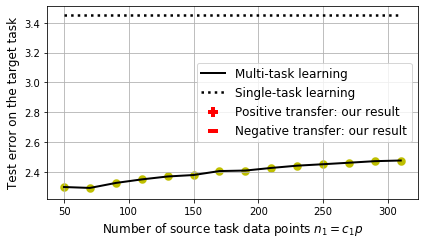

In [6]:
plt.figure(figsize=(6,3.5))

plt.scatter(provable_pos[0], provable_pos[1], marker='+', s=100, lw=4, c='r', label='Positive transfer: our result')
plt.scatter(provable_neg[0], provable_neg[1], marker='_', s=100, lw=4, c='r', label='Negative transfer: our result')
plt.scatter(unknown[0], unknown[1], marker='o', s=20, lw=4, c='y')
plt.plot(c1_list, te_mtl_list, c='k', lw=2, label='Multi-task learning')
plt.plot(c1_list, [te_beta_t] * len(c1_list), lw=2.5, c='k', ls='dotted', label='Single-task learning')
#plt.plot(c1_list, delta_beta_list, label='Delta beta')

plt.xlabel(r'Number of source task data points $n_1 = c_1 p$', fontsize=12)
plt.ylabel('Test error on the target task', fontsize=12)
plt.grid(0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('model_shift_n1_phase_transition.eps')